Using device: cpu
L shape: torch.Size([10000, 10000]), L device: cpu


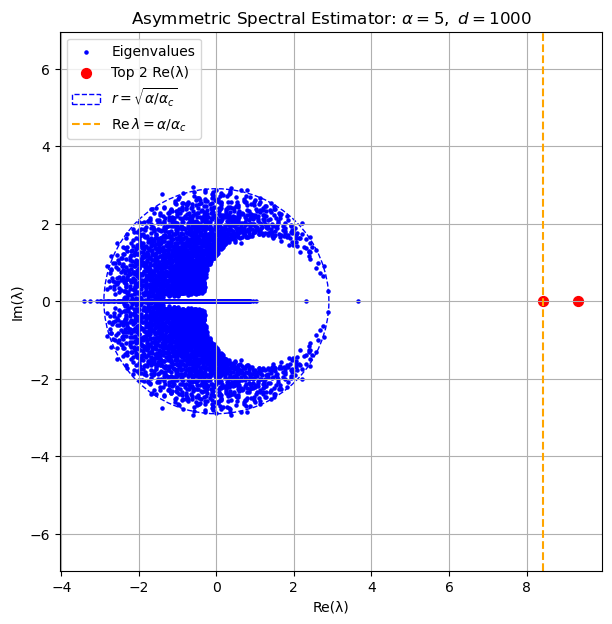

In [ ]:
import os
import random
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import kv as besselk

# Set random seed for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)

set_seed(42)

# Experiment configuration
n = 5000        # Number of samples
p = 2           # Subspace dimension
alpha = 5
alpha_c = 0.59375
d = int(n / alpha)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Generate input matrix X ∈ ℝ^{n × d}
X = torch.randn(n, d, device=device) / np.sqrt(d)

# Construct true subspace W* and observations Z = X W*
W_star = torch.randn(d, p, device=device)
Z = X @ W_star
z1, z2 = Z[:, 0], Z[:, 1]
y = z1 * z2  # Link function: y = z1 * z2

# Compute preprocessing function G(y) ∈ ℝ^{n × p × p}
y_cpu = y.detach().cpu().numpy()
abs_y = np.abs(y_cpu)
K1 = besselk(1, abs_y)
K0 = besselk(0, abs_y)
lambda_y = abs_y * (K1 / K0) - 1
lambda_y[np.isnan(lambda_y)] = 0  # Numerical stability

# Construct G(y): each sample has a 2×2 symmetric matrix
G_y_np = np.zeros((n, p, p), dtype=np.float32)
G_y_np[:, 0, 0] = lambda_y
G_y_np[:, 1, 1] = lambda_y
G_y_np[:, 0, 1] = y_cpu
G_y_np[:, 1, 0] = y_cpu
G_y = torch.tensor(G_y_np, device=device)

# Construct asymmetric spectral matrix L ∈ ℝ^{np × np}
XXT = X @ X.T  # shape: (n, n)
XXT.fill_diagonal_(0.0)  # Remove diagonal entries

# Build blocks of L: (iμ, jν) entry
A = XXT[:, :, None, None]            # shape: (n, n, 1, 1)
G_broadcast = G_y[None, :, :, :]     # shape: (1, n, p, p)
L_blocks = A * G_broadcast           # shape: (n, n, p, p)
L = L_blocks.permute(0, 2, 1, 3).reshape(n * p, n * p)  # shape: (np, np)
print(f"L shape: {L.shape}, L device: {L.device}")

# Eigenvalue computation (GPU) and visualization
eigvals = torch.linalg.eigvals(L)
eigvals_np = eigvals.detach().cpu().numpy()
eigvals_real = eigvals_np.real

# Extract top-2 eigenvalues by real part
top2_idx = np.argsort(eigvals_real)[-2:]
top2_vals = eigvals_np[top2_idx]

# Visualize eigenvalue spectrum
plt.figure(figsize=(7, 7))
plt.scatter(eigvals_np.real, eigvals_np.imag, s=5, color='blue', label='Eigenvalues')
plt.scatter(top2_vals.real, top2_vals.imag, color='red', s=50, label='Top 2 Re(λ)')

# Theoretical spectral radius and threshold
r = np.sqrt(alpha / alpha_c)
thresh = alpha / alpha_c

circle = plt.Circle((0, 0), r, color='blue', fill=False, linestyle='--',
                    label=rf'$r = \sqrt{{\alpha / \alpha_c}}$')
plt.gca().add_artist(circle)
plt.axvline(x=thresh, color='orange', linestyle='--',
            label=rf'$\mathrm{{Re}}\,\lambda = \alpha / \alpha_c$')

# Plot settings
plt.xlabel('Re(λ)')
plt.ylabel('Im(λ)')
plt.title(rf'Asymmetric Spectral Estimator: $\alpha = {alpha},\ d = {d}$')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()


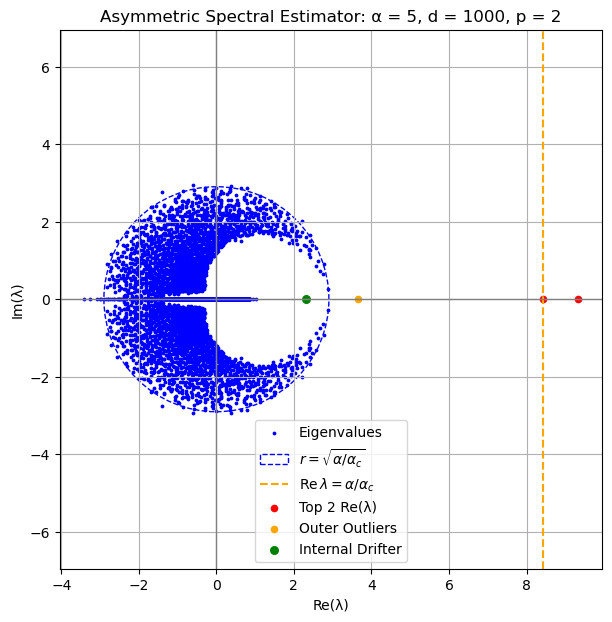

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from numpy.linalg import norm
from scipy.linalg import qr
import pandas as pd

# Compute corrected generalized overlap between estimated and true subspaces
def generalized_overlap_corrected(W_star, eigvals_np, eigvecs_np, target_vals, label_prefix, X):
    results = []
    d = W_star.shape[0]
    W_orth, _ = qr(W_star, mode='economic')  # Orthogonalize W_star
    X_cpu = X.cpu().numpy().T  # Shape: (d, n)

    for i, val in enumerate(target_vals):
        idx = np.argmin(np.abs(eigvals_np - val))
        v_hat = eigvecs_np[:, idx]  # Shape: (n*p,)
        V = v_hat.reshape(-1, 2)    # Shape: (n, 2)

        U = X_cpu @ V  # Shape: (d, 2)
        for j in range(2):
            u = U[:, j]
            u_hat = u / norm(u)
            q = norm(W_orth.T @ u_hat)**2
            results.append((f"{label_prefix}{i+1}-{j+1}", val, q))
    return results

# Eigenvalue computation and classification
eigvals, eigvecs = torch.linalg.eig(L)
eigvals_np = eigvals.cpu().numpy()
eigvecs_np = eigvecs.cpu().numpy()
W_star_np = W_star.cpu().numpy()
d = W_star_np.shape[0]

R = np.sqrt(alpha / alpha_c)        # Radius threshold
thresh_ext = alpha / alpha_c        # Theoretical jump threshold

# Filter real eigenvalues
real_mask = np.isclose(eigvals_np.imag, 0.0, atol=1e-6)
eigvals_real_only = eigvals_np[real_mask]
real_parts = eigvals_real_only.real

# Select top-10 eigenvalues by real part
top10_real_idx = np.argsort(real_parts)[-10:]
top10_real_vals = eigvals_real_only[top10_real_idx]

# Classify eigenvalues into red, orange, green candidates
red_vals = top10_real_vals[-2:]
rest_vals = top10_real_vals[:-2]

orange_vals = []
green_candidates = []
for val in rest_vals:
    if R < val.real < thresh_ext:
        orange_vals.append(val)
    elif val.real < R:
        green_candidates.append(val)

# Green point selection: largest real eigenvalue inside radius
green_single_val = None
inside_real_mask = np.logical_and(
    np.abs(eigvals_np) <= R,
    np.isclose(eigvals_np.imag, 0.0, atol=1e-6)
)
eigvals_real_inside = eigvals_np[inside_real_mask]
if eigvals_real_inside.size > 0:
    max_real_idx = np.argmax(eigvals_real_inside.real)
    green_single_val = eigvals_real_inside[max_real_idx]

# Visualization of eigenvalue spectrum
plt.figure(figsize=(7, 7))

# Plot all eigenvalues
plt.scatter(eigvals_np.real, eigvals_np.imag, color="blue", s=3, label="Eigenvalues")

# Plot spectral radius and theoretical threshold
circle = plt.Circle((0, 0), R, color="blue", linestyle="--", fill=False, label=r"$r = \sqrt{\alpha/\alpha_c}$")
plt.gca().add_artist(circle)
plt.axvline(thresh_ext, color="orange", linestyle="--", label=r"$\mathrm{Re}\,\lambda = \alpha/\alpha_c$")

# Red and orange points
plt.scatter([z.real for z in red_vals], [z.imag for z in red_vals], color="red", s=20, label="Top 2 Re(λ)")
plt.scatter([z.real for z in orange_vals], [z.imag for z in orange_vals], color="orange", s=20, label="Outer Outliers")

# Green point: largest real eigenvalue inside radius
if green_single_val is not None:
    plt.scatter(green_single_val.real, green_single_val.imag, color="green", s=30, label="Internal Drifter")

# Axis and title settings
plt.axhline(0, color='gray', linewidth=1)
plt.axvline(0, color='gray', linewidth=1)
plt.xlabel("Re(λ)")
plt.ylabel("Im(λ)")
plt.title(f"Asymmetric Spectral Estimator: α = {alpha}, d = {d}, p = 2")
plt.legend()
plt.grid(True)
plt.axis("equal")
plt.show()


In [ ]:

results_red = generalized_overlap_corrected(W_star_np, eigvals_np, eigvecs_np, red_vals, "Red", X)
results_orange = generalized_overlap_corrected(W_star_np, eigvals_np, eigvecs_np, orange_vals, "Orange", X)

results_green = []
if green_single_val is not None:
    results_green = generalized_overlap_corrected(W_star_np, eigvals_np, eigvecs_np, [green_single_val], "Green", X)

# Combine all results into a single DataFrame
df_overlap = pd.DataFrame(results_red + results_orange + results_green,
                          columns=["Label", "Eigenvalue", "Overlap_q"])
df_overlap = df_overlap.sort_values("Overlap_q", ascending=False).reset_index(drop=True)

print(df_overlap)


       Label          Eigenvalue  Overlap_q
0     Red2-2  9.318233+0.000000j   0.439460
1     Red2-1  9.318233+0.000000j   0.439460
2     Red1-2  8.425777+0.000000j   0.420235
3     Red1-1  8.425777+0.000000j   0.420235
4   Green1-1  2.314434+0.000000j   0.001786
5   Green1-2  2.314434+0.000000j   0.001786
6  Orange1-2  3.664519+0.000000j   0.001128
7  Orange1-1  3.664519+0.000000j   0.001127


In [ ]:
import numpy as np
import pandas as pd
from numpy.linalg import norm
from itertools import combinations
from scipy.linalg import qr

# Define function to compute rank-2 overlap without using Pt numbering
def rank2_overlap_from_labels(W_star, eigvals_np, eigvecs_np, df_result, X):
    results = []
    d = W_star.shape[0]
    W_orth, _ = qr(W_star, mode='economic')  # Orthogonalize W_star
    X_cpu = X.cpu().numpy().T  # Shape: (d, n)

    v_map = {}  # Map label -> eigenvector

    # Extract eigenvectors corresponding to labeled eigenvalues
    for i, row in enumerate(df_result.itertuples()):
        label = row.Label
        val = row.Eigenvalue
        idx = np.argmin(np.abs(eigvals_np - val))
        v_hat = eigvecs_np[:, idx]
        V = v_hat.reshape(-1, 2)  # Shape: (n, 2)
        j = 0 if '1' in label[-3:] else 1  # Determine direction based on label suffix
        v_map[label] = V[:, j]

    # Enumerate all unique label combinations
    for (id1, v1), (id2, v2) in combinations(v_map.items(), 2):
        U = X_cpu @ np.column_stack([v1, v2])  # Shape: (d, 2)
        U, _ = qr(U, mode='economic')  # Orthonormalize columns
        q = np.linalg.norm(W_orth.T @ U, ord='fro')**2  # Squared Frobenius norm
        results.append((f"{id1} + {id2}", q))

    return pd.DataFrame(results, columns=["ComboLabel", "Rank2_Overlap_q"]) \
             .sort_values("Rank2_Overlap_q", ascending=False) \
             .reset_index(drop=True)


df_rank2 = rank2_overlap_from_labels(W_star_np, eigvals_np, eigvecs_np, df_overlap, X)

# Display the full results
pd.set_option("display.max_rows", None)
print(df_rank2)


               ComboLabel  Rank2_Overlap_q
0         Red2-1 + Red1-2         0.859771
1         Red2-1 + Red1-1         0.859771
2         Red2-2 + Red1-1         0.859770
3         Red2-2 + Red1-2         0.859770
4         Red2-2 + Red2-1         0.850590
5       Red2-1 + Green1-1         0.441408
6       Red2-1 + Green1-2         0.441408
7       Red2-2 + Green1-1         0.441407
8       Red2-2 + Green1-2         0.441407
9      Red2-1 + Orange1-2         0.440170
10     Red2-1 + Orange1-1         0.440170
11     Red2-2 + Orange1-2         0.440169
12     Red2-2 + Orange1-1         0.440169
13      Red1-1 + Green1-1         0.421736
14      Red1-1 + Green1-2         0.421736
15      Red1-2 + Green1-1         0.421736
16      Red1-2 + Green1-2         0.421736
17     Red1-2 + Orange1-2         0.421103
18     Red1-2 + Orange1-1         0.421103
19     Red1-1 + Orange1-2         0.421103
20     Red1-1 + Orange1-1         0.421103
21        Red1-2 + Red1-1         0.420568
22    Green

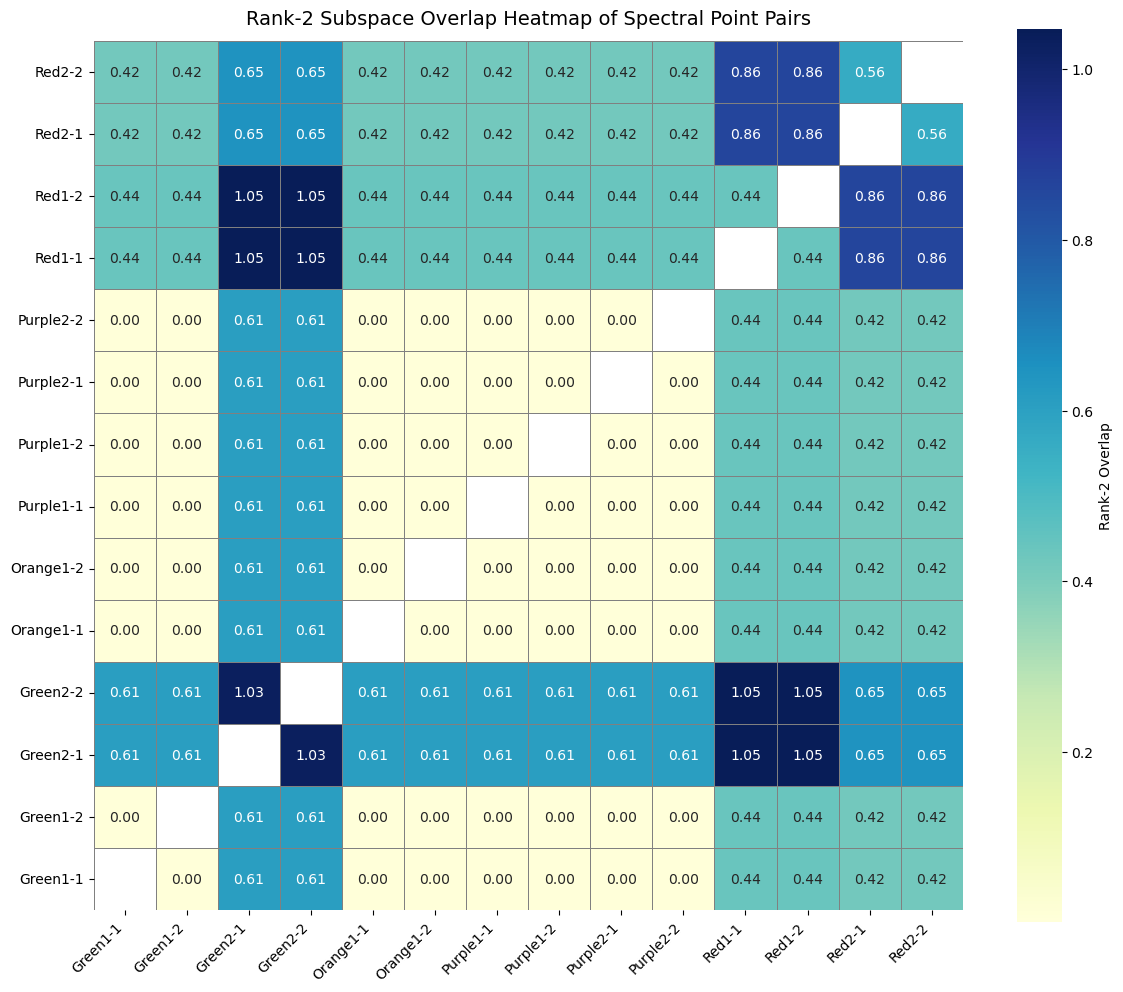

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Assumes df_rank2 exists with:
# - "ComboLabel" (e.g., "Green2-1 + Red2-2")
# - "Rank2_Overlap_q" (numeric)

# Extract unique point labels
all_labels = sorted(set(sum([label.split(' + ') for label in df_rank2['ComboLabel']], [])))

# Initialize a symmetric matrix
heatmap_matrix = pd.DataFrame(np.nan, index=all_labels, columns=all_labels)

# Populate upper/lower triangles
for _, row in df_rank2.iterrows():
    a, b = row['ComboLabel'].split(' + ')
    heatmap_matrix.loc[a, b] = row['Rank2_Overlap_q']
    heatmap_matrix.loc[b, a] = row['Rank2_Overlap_q']

# Set diagonal to NaN (omit self-pairs)
np.fill_diagonal(heatmap_matrix.values, np.nan)

# Select top-5 pairs by rank-2 overlap
top5 = df_rank2.nlargest(5, 'Rank2_Overlap_q')

# Plot heatmap
plt.figure(figsize=(12, 10))
ax = sns.heatmap(
    heatmap_matrix, annot=True, fmt=".2f", cmap="YlGnBu", square=True,
    cbar_kws={'label': 'Rank-2 Overlap'}, linewidths=0.5, linecolor='gray'
)

plt.title("Rank-2 Subspace Overlap Heatmap of Spectral Point Pairs", fontsize=14, pad=12)

# Add red boxes to highlight top-5 pairs (optional; coordinates to be computed if needed)

# Axis formatting
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
ax.invert_yaxis()

plt.tight_layout()
plt.show()


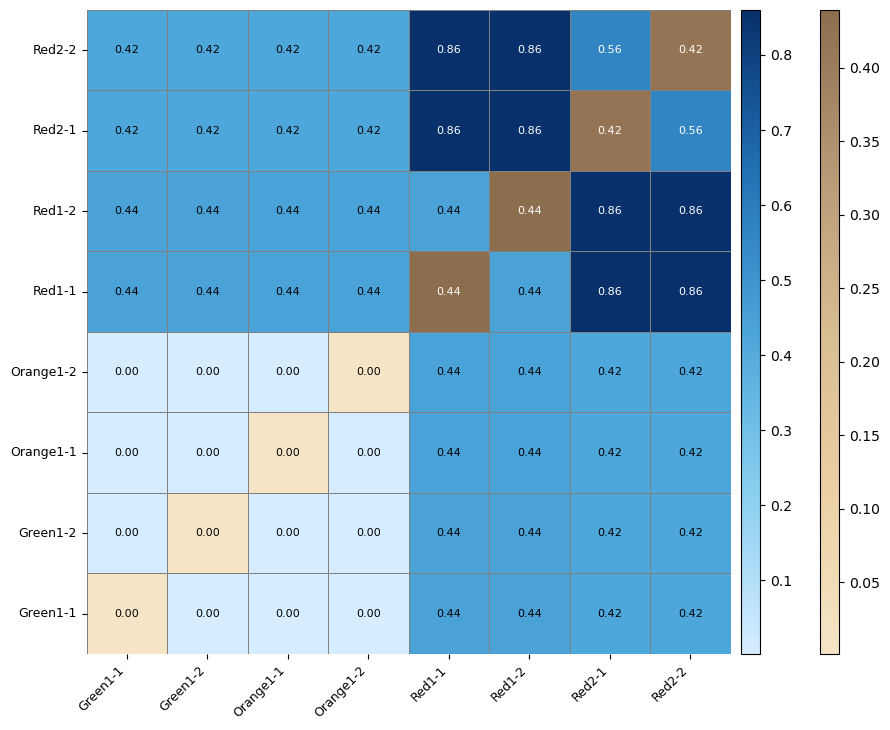

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, to_rgb
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.cm import ScalarMappable

# Collect all unique labels from rank-1 and rank-2 results
labels_rank1 = set(df_result["Label"])
labels_rank2 = set()
for combo in df_rank2["ComboLabel"]:
    a, b = combo.split(" + ")
    labels_rank2.add(a)
    labels_rank2.add(b)

# Merge labels into a unified list
all_labels = sorted(labels_rank1.union(labels_rank2))

# Sort labels by group (Green → Orange → Red)
color_order = ["Green", "Orange", "Red"]
sorted_labels = []
for color in color_order:
    group = [label for label in all_labels if color.lower() in label.lower()]
    sorted_labels.extend(sorted(group))

# Initialize heatmap matrix
heatmap_matrix = pd.DataFrame(np.nan, index=sorted_labels, columns=sorted_labels)

# Fill rank-2 overlap values
for _, row in df_rank2.iterrows():
    a, b = row['ComboLabel'].split(' + ')
    if a in heatmap_matrix.index and b in heatmap_matrix.columns:
        heatmap_matrix.loc[a, b] = row['Rank2_Overlap_q']
        heatmap_matrix.loc[b, a] = row['Rank2_Overlap_q']

# Fill rank-1 overlap values (diagonal entries)
for _, row in df_result.iterrows():
    label = row['Label']
    if label in heatmap_matrix.index:
        heatmap_matrix.loc[label, label] = row['Overlap_q']

# Build masks for separating rank-1 and rank-2 values
mask_rank1 = ~np.eye(len(sorted_labels), dtype=bool)
mask_rank2 = np.eye(len(sorted_labels), dtype=bool)

# Define custom colormaps for rank-2 (blue) and rank-1 (brown)
cmap_rank2 = LinearSegmentedColormap.from_list("bright_blue_gradient", [
    "#D6ECFF", "#89CFF0", "#4CA5D9", "#2171B5", "#08306B"
])
cmap_rank1 = LinearSegmentedColormap.from_list("custom_rank1_softbrown", [
    "#F5E5C6", "#EBD0A4", "#D7BD92", "#B99876", "#8C6D4E"
])

# Determine value ranges for color scaling
rank1_values = heatmap_matrix.values[np.eye(len(sorted_labels), dtype=bool)]
rank2_values = heatmap_matrix.values[~np.eye(len(sorted_labels), dtype=bool)]
rank1_min, rank1_max = np.nanmin(rank1_values), np.nanmax(rank1_values)
rank2_min, rank2_max = np.nanmin(rank2_values), np.nanmax(rank2_values)

# Automatic text color based on luminance for better contrast
def get_text_color(value, cmap, vmin, vmax):
    rgba = cmap((value - vmin) / (vmax - vmin))
    r, g, b = to_rgb(rgba[:3])
    luminance = 0.299 * r + 0.587 * g + 0.114 * b
    return 'black' if luminance > 0.5 else 'white'

# Create heatmap figure
fig, ax = plt.subplots(figsize=(9, 8))

# Plot rank-2 overlaps (off-diagonal)
sns.heatmap(
    heatmap_matrix,
    mask=mask_rank2,
    cmap=cmap_rank2,
    annot=False,
    square=True,
    cbar=False,
    linewidths=0.5,
    linecolor='gray',
    ax=ax
)

# Plot rank-1 overlaps (diagonal)
sns.heatmap(
    heatmap_matrix,
    mask=mask_rank1,
    cmap=cmap_rank1,
    annot=False,
    square=True,
    cbar=False,
    linewidths=0.5,
    linecolor='gray',
    ax=ax
)

# Add text annotations for all values
for i in range(len(sorted_labels)):
    for j in range(len(sorted_labels)):
        value = heatmap_matrix.iloc[i, j]
        if pd.isna(value):
            continue
        is_rank1 = (i == j)
        cmap = cmap_rank1 if is_rank1 else cmap_rank2
        vmin = rank1_min if is_rank1 else rank2_min
        vmax = rank1_max if is_rank1 else rank2_max
        color = get_text_color(value, cmap, vmin, vmax)
        ax.text(j + 0.5, i + 0.5, f"{value:.2f}", 
                ha='center', va='center', color=color, fontsize=8)

# Add dual colorbars for rank-2 (blue) and rank-1 (brown)
divider = make_axes_locatable(ax)
cax1 = divider.append_axes("right", size="3%", pad=0.1)
cax2 = divider.append_axes("right", size="3%", pad=0.6)

sm1 = ScalarMappable(cmap=cmap_rank2, norm=plt.Normalize(rank2_min, rank2_max))
sm1.set_array([])
fig.colorbar(sm1, cax=cax1)

sm2 = ScalarMappable(cmap=cmap_rank1, norm=plt.Normalize(rank1_min, rank1_max))
sm2.set_array([])
fig.colorbar(sm2, cax=cax2)

# Final axis formatting
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=9)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=9)
ax.invert_yaxis()
plt.tight_layout()
plt.show()


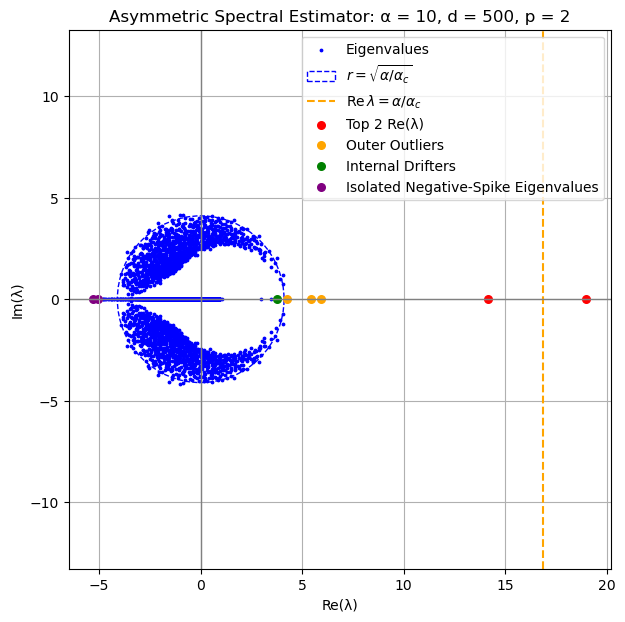


=== Rank-1 Overlap Summary ===
        Label  Overlap_q
0      Red1-2   0.624795
1      Red1-1   0.624794
2      Red2-1   0.599594
3      Red2-2   0.599594
4   Purple1-2   0.007703
5   Purple1-1   0.007703
6   Purple2-2   0.001524
7   Purple2-1   0.001524
8    Green1-2   0.001422
9    Green1-1   0.001422
10  Orange3-1   0.001357
11  Orange3-2   0.001357
12  Orange2-1   0.000842
13  Orange2-2   0.000842
14  Orange1-2   0.000820
15  Orange1-1   0.000820
Mean: 0.1548 | Max: 0.6248 | Min: 0.0008

===  Rank-2 Overlap Combinations ===
                ComboLabel  Rank2_Overlap_q
0          Red1-2 + Red2-2         0.612905
1          Red1-1 + Red2-2         0.612905
2          Red1-2 + Red2-1         0.612905
3          Red1-1 + Red2-1         0.612905
4          Red2-1 + Red2-2         0.450917
..                     ...              ...
115  Orange2-2 + Orange1-1         0.000879
116   Green1-1 + Orange3-1         0.000817
117   Green1-2 + Orange3-1         0.000817
118   Green1-1 + Orange3

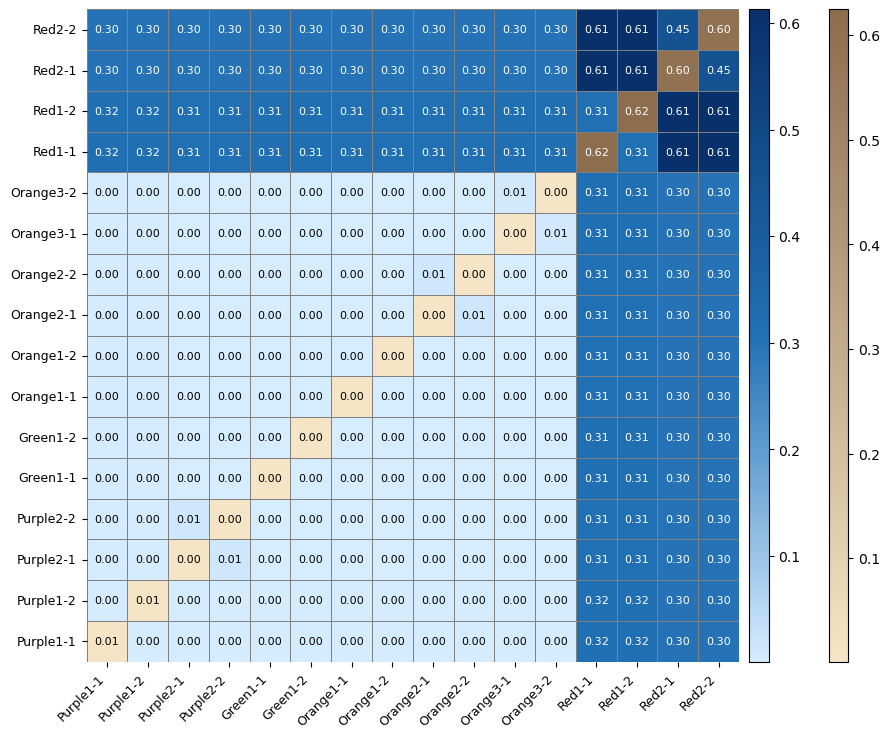

In [ ]:
import os, random
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.linalg import qr
from scipy.special import kv as besselk
from matplotlib.colors import LinearSegmentedColormap, to_rgb
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.cm import ScalarMappable

# Utility functions
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

def get_text_color(value, cmap, vmin, vmax):
    rgba = cmap((value - vmin) / (vmax - vmin))
    r, g, b = to_rgb(rgba[:3])
    luminance = 0.299 * r + 0.587 * g + 0.114 * b
    return 'black' if luminance > 0.5 else 'white'

def generalized_overlap_corrected(W_star, eigvals_np, eigvecs_np, target_vals, label_prefix, X):
    results = []
    d = W_star.shape[0]
    W_orth, _ = qr(W_star, mode='economic')  # Orthonormalize W*
    X_cpu = X.cpu().numpy().T  # Shape: (d, n)
    for i, val in enumerate(target_vals):
        idx = np.argmin(np.abs(eigvals_np - val))
        v_hat = eigvecs_np[:, idx]
        V = v_hat.reshape(-1, 2)
        U = X_cpu @ V
        for j in range(2):
            u = U[:, j]
            u_hat = u / np.linalg.norm(u)
            q = np.linalg.norm(W_orth.T @ u_hat)**2
            results.append((f"{label_prefix}{i+1}-{j+1}", val, q))
    return results

def rank2_overlap_from_labels(W_star_np, eigvals_np, eigvecs_np, df_result, X, normalize=True):
    """
    Compute rank-2 overlap and optionally normalize to [0, 1].

    Parameters
    ----------
    W_star_np : array-like, shape (d, p)
        Ground-truth subspace.
    eigvals_np : array-like, shape (n*p,)
        All eigenvalues.
    eigvecs_np : array-like, shape (n*p, n*p)
        All eigenvectors.
    df_result : pandas.DataFrame
        DataFrame containing each target eigenvalue with its label, value, and overlap_q.
    X : torch.Tensor, shape (n, d)
        Original input matrix.
    normalize : bool, default True
        If True, divide the Frobenius overlap by 2 to map to [0, 1] for p=2.

    Returns
    -------
    pandas.DataFrame
        Pair labels with normalized (or raw) rank-2 overlap.
    """
    results = []
    W_orth, _ = qr(W_star_np, mode='economic')
    X_cpu = X.cpu().numpy().T  # (d × n)
    v_map = {}

    for row in df_result.itertuples():
        label = row.Label
        val = row.Eigenvalue
        idx = np.argmin(np.abs(eigvals_np - val))
        v_hat = eigvecs_np[:, idx].reshape(-1, 2)
        j = 0 if '1' in label[-3:] else 1
        v_map[label] = v_hat[:, j]

    for (id1, v1), (id2, v2) in combinations(v_map.items(), 2):
        U = X_cpu @ np.column_stack([v1, v2])  # (d × 2)
        U, _ = qr(U, mode='economic')
        q = np.linalg.norm(W_orth.T @ U, ord='fro')**2  # In [0, 2]
        if normalize:
            q /= 2.0
        results.append((f"{id1} + {id2}", q))

    return pd.DataFrame(results, columns=["ComboLabel", "Rank2_Overlap_q"]) \
             .sort_values("Rank2_Overlap_q", ascending=False).reset_index(drop=True)


# Configuration
set_seed(998)
n, p = 5000, 2

alpha = 10
alpha_c = 0.59375
R = np.sqrt(alpha / alpha_c)        # Spectral radius threshold
thresh_ext = alpha / alpha_c        # Real-axis jump threshold

d = int(n / alpha)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data generation
X = torch.randn(n, d, device=device) / np.sqrt(d)
W_star = torch.randn(d, p, device=device)
Z = X @ W_star
z1, z2 = Z[:, 0], Z[:, 1]
y = z1 * z2

# Construct G(y)
y_cpu = y.detach().cpu().numpy()
abs_y = np.abs(y_cpu)
K1, K0 = besselk(1, abs_y), besselk(0, abs_y)
lambda_y = abs_y * (K1 / K0) - 1
lambda_y[np.isnan(lambda_y)] = 0

G_y_np = np.zeros((n, p, p), dtype=np.float32)
G_y_np[:, 0, 0] = lambda_y
G_y_np[:, 1, 1] = lambda_y
G_y_np[:, 0, 1] = y_cpu
G_y_np[:, 1, 0] = y_cpu
G_y = torch.tensor(G_y_np, device=device)

# Build spectral matrix
XXT = X @ X.T
XXT.fill_diagonal_(0.0)
A = XXT[:, :, None, None]
G_broadcast = G_y[None, :, :, :]
L_blocks = A * G_broadcast
L = L_blocks.permute(0, 2, 1, 3).reshape(n * p, n * p)

# Eigendecomposition and classification
eigvals, eigvecs = torch.linalg.eig(L)
eigvals_np = eigvals.cpu().numpy()
eigvecs_np = eigvecs.cpu().numpy()
W_star_np = W_star.cpu().numpy()

R = np.sqrt(alpha / alpha_c)
real_mask = np.isclose(eigvals_np.imag, 0.0, atol=1e-6)
eigvals_real = eigvals_np[real_mask]

red_vals = sorted(eigvals_real, key=lambda z: z.real, reverse=True)[:2]
orange_vals = [z for z in eigvals_real if abs(z) > R and z.real > 0 and z not in red_vals]
green_vals = sorted([z for z in eigvals_real if abs(z) <= R and z.real > 0], key=lambda z: z.real, reverse=True)[:1]
purple_vals = [z for z in eigvals_real if z.real < 0 and abs(z) > R][:2]

# Spectrum plot
red_labels = [(f"Red{i+1}", z) for i, z in enumerate(red_vals)]
orange_labels = [(f"Orange{i+1}", z) for i, z in enumerate(orange_vals)]
green_labels = [(f"Green{i+1}", z) for i, z in enumerate(green_vals)]
purple_labels = [(f"Purple{i+1}", z) for i, z in enumerate(purple_vals)]

plt.figure(figsize=(7, 7))
plt.scatter(eigvals_np.real, eigvals_np.imag, color="blue", s=3, label="Eigenvalues")
circle = plt.Circle((0, 0), R, color="blue", linestyle="--", fill=False, label=r"$r = \sqrt{\alpha/\alpha_c}$")
plt.gca().add_artist(circle)
plt.axvline(thresh_ext, color="orange", linestyle="--", label=r"$\mathrm{Re}\,\lambda = \alpha/\alpha_c$")
plt.scatter([z.real for _, z in red_labels], [z.imag for _, z in red_labels], color="red", s=30, label="Top 2 Re(λ)")
plt.scatter([z.real for _, z in orange_labels], [z.imag for _, z in orange_labels], color="orange", s=30, label="Outer Outliers")
plt.scatter([z.real for _, z in green_labels], [z.imag for _, z in green_labels], color="green", s=30, label="Internal Drifters")
plt.scatter([z.real for _, z in purple_labels], [z.imag for _, z in purple_labels], color="purple", s=30, label="Isolated Negative-Spike Eigenvalues")
plt.axhline(0, color='gray', linewidth=1)
plt.axvline(0, color='gray', linewidth=1)
plt.xlabel("Re(λ)")
plt.ylabel("Im(λ)")
plt.title(f"Asymmetric Spectral Estimator: α = {alpha}, d = {d}, p = 2")
plt.legend()
plt.grid(True)
plt.axis("equal")
plt.show()

# Rank-1 overlap and summary
df_result = pd.DataFrame(
    generalized_overlap_corrected(W_star_np, eigvals_np, eigvecs_np, red_vals, "Red", X) +
    generalized_overlap_corrected(W_star_np, eigvals_np, eigvecs_np, orange_vals, "Orange", X) +
    generalized_overlap_corrected(W_star_np, eigvals_np, eigvecs_np, green_vals, "Green", X) +
    generalized_overlap_corrected(W_star_np, eigvals_np, eigvecs_np, purple_vals, "Purple", X),
    columns=["Label", "Eigenvalue", "Overlap_q"]
).sort_values("Overlap_q", ascending=False).reset_index(drop=True)

print("\n=== Rank-1 Overlap Summary ===")
print(df_result[["Label", "Overlap_q"]])
print(f"Mean: {df_result['Overlap_q'].mean():.4f} | Max: {df_result['Overlap_q'].max():.4f} | Min: {df_result['Overlap_q'].min():.4f}")

# Rank-2 overlap
df_rank2 = rank2_overlap_from_labels(W_star_np, eigvals_np, eigvecs_np, df_result, X)
print("\n===  Rank-2 Overlap Combinations ===")
print(df_rank2)

# Heatmap construction and plotting
labels_rank1 = set(df_result["Label"])
labels_rank2 = set()
for combo in df_rank2["ComboLabel"]:
    a, b = combo.split(" + ")
    labels_rank2.update([a, b])
all_labels = sorted(labels_rank1.union(labels_rank2))
color_order = ["Purple", "Green", "Orange", "Red"]
sorted_labels = []
for color in color_order:
    sorted_labels.extend(sorted([l for l in all_labels if color.lower() in l.lower()]))

heatmap_matrix = pd.DataFrame(np.nan, index=sorted_labels, columns=sorted_labels)
for _, row in df_rank2.iterrows():
    a, b = row['ComboLabel'].split(' + ')
    heatmap_matrix.loc[a, b] = row['Rank2_Overlap_q']
    heatmap_matrix.loc[b, a] = row['Rank2_Overlap_q']
for _, row in df_result.iterrows():
    heatmap_matrix.loc[row['Label'], row['Label']] = row['Overlap_q']

cmap_rank2 = LinearSegmentedColormap.from_list("blue_grad", ["#D6ECFF", "#2171B5", "#08306B"])
cmap_rank1 = LinearSegmentedColormap.from_list("brown_grad", ["#F5E5C6", "#8C6D4E"])
rank1_vals = heatmap_matrix.values[np.eye(len(sorted_labels), dtype=bool)]
rank2_vals = heatmap_matrix.values[~np.eye(len(sorted_labels), dtype=bool)]
rank1_min, rank1_max = np.nanmin(rank1_vals), np.nanmax(rank1_vals)
rank2_min, rank2_max = np.nanmin(rank2_vals), np.nanmax(rank2_vals)

fig, ax = plt.subplots(figsize=(9, 8))
mask_rank1 = ~np.eye(len(sorted_labels), dtype=bool)
mask_rank2 = np.eye(len(sorted_labels), dtype=bool)

sns.heatmap(heatmap_matrix, mask=mask_rank2, cmap=cmap_rank2, annot=False, square=True,
            cbar=False, linewidths=0.5, linecolor='gray', ax=ax)
sns.heatmap(heatmap_matrix, mask=mask_rank1, cmap=cmap_rank1, annot=False, square=True,
            cbar=False, linewidths=0.5, linecolor='gray', ax=ax)

for i in range(len(sorted_labels)):
    for j in range(len(sorted_labels)):
        value = heatmap_matrix.iloc[i, j]
        if pd.isna(value):
            continue
        is_rank1 = (i == j)
        cmap = cmap_rank1 if is_rank1 else cmap_rank2
        vmin = rank1_min if is_rank1 else rank2_min
        vmax = rank1_max if is_rank1 else rank2_max
        color = get_text_color(value, cmap, vmin, vmax)
        ax.text(j + 0.5, i + 0.5, f"{value:.2f}", ha='center', va='center', color=color, fontsize=8)

divider = make_axes_locatable(ax)
cax1 = divider.append_axes("right", size="3%", pad=0.1)
cax2 = divider.append_axes("right", size="3%", pad=0.6)
fig.colorbar(ScalarMappable(cmap=cmap_rank2, norm=plt.Normalize(rank2_min, rank2_max)), cax=cax1)
fig.colorbar(ScalarMappable(cmap=cmap_rank1, norm=plt.Normalize(rank1_min, rank1_max)), cax=cax2)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=9)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=9)
ax.invert_yaxis()
plt.tight_layout()
plt.show()


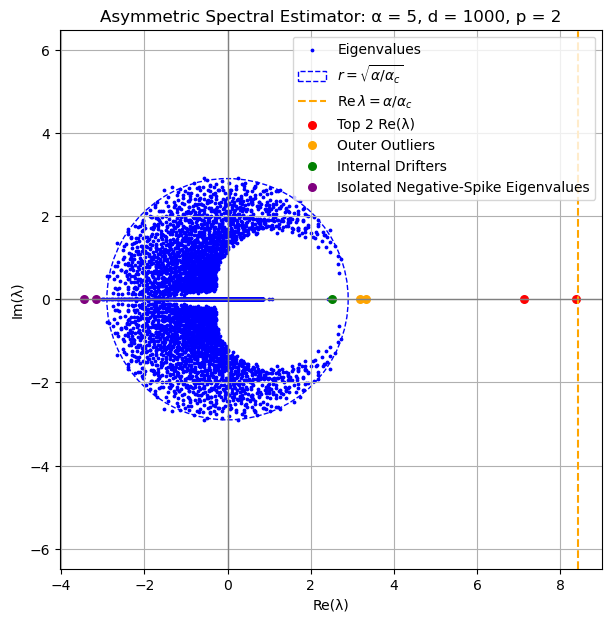


=== Rank-1 Overlap Summary ===
        Label  Overlap_q
0      Red2-2   0.400901
1      Red2-1   0.400901
2      Red1-2   0.380190
3      Red1-1   0.380190
4   Purple1-1   0.001737
5   Purple1-2   0.001737
6   Orange1-1   0.000449
7   Orange1-2   0.000449
8   Purple2-1   0.000443
9   Purple2-2   0.000443
10   Green1-2   0.000173
11   Green1-1   0.000173
12  Orange2-2   0.000074
13  Orange2-1   0.000074
Mean: 0.1120 | Max: 0.4009 | Min: 0.0001

===  Rank-2 Overlap Combinations ===
              ComboLabel  Rank2_Overlap_q
0        Red2-1 + Red1-2         0.781494
1        Red2-1 + Red1-1         0.781494
2        Red2-2 + Red1-1         0.781494
3        Red2-2 + Red1-2         0.781494
4        Red2-2 + Red2-1         0.404553
..                   ...              ...
86  Orange1-2 + Green1-1         0.000451
87  Green1-2 + Orange2-1         0.000208
88  Green1-1 + Orange2-1         0.000208
89  Green1-2 + Orange2-2         0.000208
90  Green1-1 + Orange2-2         0.000208

[91 rows 

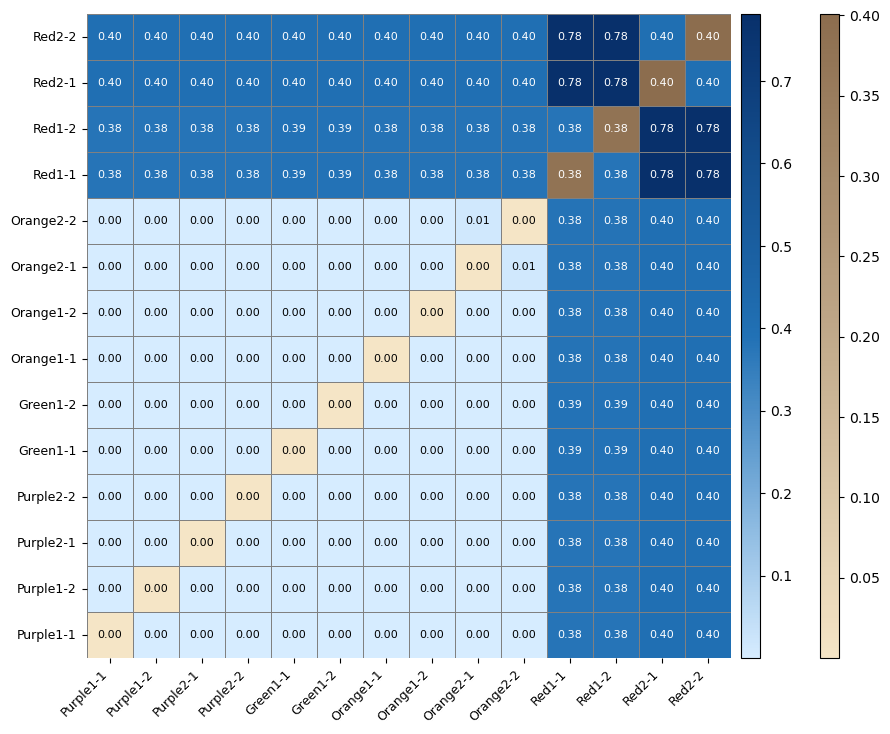

In [ ]:
# Dependencies
import os, random
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.linalg import qr
from scipy.special import kv as besselk
from matplotlib.colors import LinearSegmentedColormap, to_rgb
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.cm import ScalarMappable

# Utilities
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

def get_text_color(value, cmap, vmin, vmax):
    rgba = cmap((value - vmin) / (vmax - vmin))
    r, g, b = to_rgb(rgba[:3])
    luminance = 0.299 * r + 0.587 * g + 0.114 * b
    return 'black' if luminance > 0.5 else 'white'

def generalized_overlap_corrected(W_star, eigvals_np, eigvecs_np, target_vals, label_prefix, X):
    results = []
    d = W_star.shape[0]
    W_orth, _ = qr(W_star, mode='economic')
    X_cpu = X.cpu().numpy().T
    for i, val in enumerate(target_vals):
        idx = np.argmin(np.abs(eigvals_np - val))
        v_hat = eigvecs_np[:, idx]
        V = v_hat.reshape(-1, 2)
        U = X_cpu @ V
        for j in range(2):
            u = U[:, j]
            u_hat = u / np.linalg.norm(u)
            q = np.linalg.norm(W_orth.T @ u_hat)**2
            results.append((f"{label_prefix}{i+1}-{j+1}", val, q))
    return results

def rank2_overlap_from_labels(W_star_np, eigvals_np, eigvecs_np, df_result, X):
    results = []
    W_orth, _ = qr(W_star_np, mode='economic')
    X_cpu = X.cpu().numpy().T
    v_map = {}
    for row in df_result.itertuples():
        label = row.Label
        val = row.Eigenvalue
        idx = np.argmin(np.abs(eigvals_np - val))
        v_hat = eigvecs_np[:, idx].reshape(-1, 2)
        j = 0 if '1' in label[-3:] else 1
        v_map[label] = v_hat[:, j]
    for (id1, v1), (id2, v2) in combinations(v_map.items(), 2):
        U = X_cpu @ np.column_stack([v1, v2])
        U, _ = qr(U, mode='economic')
        q = np.linalg.norm(W_orth.T @ U, ord='fro')**2
        results.append((f"{id1} + {id2}", q))
    return pd.DataFrame(results, columns=["ComboLabel", "Rank2_Overlap_q"]) \
             .sort_values("Rank2_Overlap_q", ascending=False).reset_index(drop=True)

# Configuration
set_seed(398)
n, p = 5000, 2

alpha = 5
alpha_c = 0.59375
R = np.sqrt(alpha / alpha_c)        # Spectral radius threshold
thresh_ext = alpha / alpha_c        # Real-axis jump threshold

d = int(n / alpha)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data generation
X = torch.randn(n, d, device=device) / np.sqrt(d)
W_star = torch.randn(d, p, device=device)
Z = X @ W_star
z1, z2 = Z[:, 0], Z[:, 1]
y = z1 * z2

# Construct G(y)
y_cpu = y.detach().cpu().numpy()
abs_y = np.abs(y_cpu)
K1, K0 = besselk(1, abs_y), besselk(0, abs_y)
lambda_y = abs_y * (K1 / K0) - 1
lambda_y[np.isnan(lambda_y)] = 0

G_y_np = np.zeros((n, p, p), dtype=np.float32)
G_y_np[:, 0, 0] = lambda_y
G_y_np[:, 1, 1] = lambda_y
G_y_np[:, 0, 1] = y_cpu
G_y_np[:, 1, 0] = y_cpu
G_y = torch.tensor(G_y_np, device=device)

# Build spectral matrix
XXT = X @ X.T
XXT.fill_diagonal_(0.0)
A = XXT[:, :, None, None]
G_broadcast = G_y[None, :, :, :]
L_blocks = A * G_broadcast
L = L_blocks.permute(0, 2, 1, 3).reshape(n * p, n * p)

# Eigendecomposition and classification
eigvals, eigvecs = torch.linalg.eig(L)
eigvals_np = eigvals.cpu().numpy()
eigvecs_np = eigvecs.cpu().numpy()
W_star_np = W_star.cpu().numpy()

R = np.sqrt(alpha / alpha_c)
real_mask = np.isclose(eigvals_np.imag, 0.0, atol=1e-6)
eigvals_real = eigvals_np[real_mask]

red_vals = sorted(eigvals_real, key=lambda z: z.real, reverse=True)[:2]
orange_vals = [z for z in eigvals_real if abs(z) > R and z.real > 0 and z not in red_vals]
green_vals = sorted([z for z in eigvals_real if abs(z) <= R and z.real > 0], key=lambda z: z.real, reverse=True)[:1]
purple_vals = [z for z in eigvals_real if z.real < 0 and abs(z) > R][:2]

# Spectrum plot
red_labels = [(f"Red{i+1}", z) for i, z in enumerate(red_vals)]
orange_labels = [(f"Orange{i+1}", z) for i, z in enumerate(orange_vals)]
green_labels = [(f"Green{i+1}", z) for i, z in enumerate(green_vals)]
purple_labels = [(f"Purple{i+1}", z) for i, z in enumerate(purple_vals)]

plt.figure(figsize=(7, 7))
plt.scatter(eigvals_np.real, eigvals_np.imag, color="blue", s=3, label="Eigenvalues")
circle = plt.Circle((0, 0), R, color="blue", linestyle="--", fill=False, label=r"$r = \sqrt{\alpha/\alpha_c}$")
plt.gca().add_artist(circle)
plt.axvline(thresh_ext, color="orange", linestyle="--", label=r"$\mathrm{Re}\,\lambda = \alpha/\alpha_c$")
plt.scatter([z.real for _, z in red_labels], [z.imag for _, z in red_labels], color="red", s=30, label="Top 2 Re(λ)")
plt.scatter([z.real for _, z in orange_labels], [z.imag for _, z in orange_labels], color="orange", s=30, label="Outer Outliers")
plt.scatter([z.real for _, z in green_labels], [z.imag for _, z in green_labels], color="green", s=30, label="Internal Drifters")
plt.scatter([z.real for _, z in purple_labels], [z.imag for _, z in purple_labels], color="purple", s=30, label="Isolated Negative-Spike Eigenvalues")
plt.axhline(0, color='gray', linewidth=1)
plt.axvline(0, color='gray', linewidth=1)
plt.xlabel("Re(λ)")
plt.ylabel("Im(λ)")
plt.title(f"Asymmetric Spectral Estimator: α = {alpha}, d = {d}, p = 2")
plt.legend()
plt.grid(True)
plt.axis("equal")
plt.show()

# Rank-1 overlap summary
df_result = pd.DataFrame(
    generalized_overlap_corrected(W_star_np, eigvals_np, eigvecs_np, red_vals, "Red", X) +
    generalized_overlap_corrected(W_star_np, eigvals_np, eigvecs_np, orange_vals, "Orange", X) +
    generalized_overlap_corrected(W_star_np, eigvals_np, eigvecs_np, green_vals, "Green", X) +
    generalized_overlap_corrected(W_star_np, eigvals_np, eigvecs_np, purple_vals, "Purple", X),
    columns=["Label", "Eigenvalue", "Overlap_q"]
).sort_values("Overlap_q", ascending=False).reset_index(drop=True)

print("\n=== Rank-1 Overlap Summary ===")
print(df_result[["Label", "Overlap_q"]])
print(f"Mean: {df_result['Overlap_q'].mean():.4f} | Max: {df_result['Overlap_q'].max():.4f} | Min: {df_result['Overlap_q'].min():.4f}")

# Rank-2 overlap
df_rank2 = rank2_overlap_from_labels(W_star_np, eigvals_np, eigvecs_np, df_result, X)
print("\n===  Rank-2 Overlap Combinations ===")
print(df_rank2)

# Heatmap construction and plotting
labels_rank1 = set(df_result["Label"])
labels_rank2 = set()
for combo in df_rank2["ComboLabel"]:
    a, b = combo.split(" + ")
    labels_rank2.update([a, b])
all_labels = sorted(labels_rank1.union(labels_rank2))
color_order = ["Purple", "Green", "Orange", "Red"]
sorted_labels = []
for color in color_order:
    sorted_labels.extend(sorted([l for l in all_labels if color.lower() in l.lower()]))

heatmap_matrix = pd.DataFrame(np.nan, index=sorted_labels, columns=sorted_labels)
for _, row in df_rank2.iterrows():
    a, b = row['ComboLabel'].split(' + ')
    heatmap_matrix.loc[a, b] = row['Rank2_Overlap_q']
    heatmap_matrix.loc[b, a] = row['Rank2_Overlap_q']
for _, row in df_result.iterrows():
    heatmap_matrix.loc[row['Label'], row['Label']] = row['Overlap_q']

cmap_rank2 = LinearSegmentedColormap.from_list("blue_grad", ["#D6ECFF", "#2171B5", "#08306B"])
cmap_rank1 = LinearSegmentedColormap.from_list("brown_grad", ["#F5E5C6", "#8C6D4E"])
rank1_vals = heatmap_matrix.values[np.eye(len(sorted_labels), dtype=bool)]
rank2_vals = heatmap_matrix.values[~np.eye(len(sorted_labels), dtype=bool)]
rank1_min, rank1_max = np.nanmin(rank1_vals), np.nanmax(rank1_vals)
rank2_min, rank2_max = np.nanmin(rank2_vals), np.nanmax(rank2_vals)

fig, ax = plt.subplots(figsize=(9, 8))
mask_rank1 = ~np.eye(len(sorted_labels), dtype=bool)
mask_rank2 = np.eye(len(sorted_labels), dtype=bool)

sns.heatmap(heatmap_matrix, mask=mask_rank2, cmap=cmap_rank2, annot=False, square=True,
            cbar=False, linewidths=0.5, linecolor='gray', ax=ax)
sns.heatmap(heatmap_matrix, mask=mask_rank1, cmap=cmap_rank1, annot=False, square=True,
            cbar=False, linewidths=0.5, linecolor='gray', ax=ax)

for i in range(len(sorted_labels)):
    for j in range(len(sorted_labels)):
        value = heatmap_matrix.iloc[i, j]
        if pd.isna(value):
            continue
        is_rank1 = (i == j)
        cmap = cmap_rank1 if is_rank1 else cmap_rank2
        vmin = rank1_min if is_rank1 else rank2_min
        vmax = rank1_max if is_rank1 else rank2_max
        color = get_text_color(value, cmap, vmin, vmax)
        ax.text(j + 0.5, i + 0.5, f"{value:.2f}", ha='center', va='center', color=color, fontsize=8)

divider = make_axes_locatable(ax)
cax1 = divider.append_axes("right", size="3%", pad=0.1)
cax2 = divider.append_axes("right", size="3%", pad=0.6)
fig.colorbar(ScalarMappable(cmap=cmap_rank2, norm=plt.Normalize(rank2_min, rank2_max)), cax=cax1)
fig.colorbar(ScalarMappable(cmap=cmap_rank1, norm=plt.Normalize(rank1_min, rank1_max)), cax=cax2)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=9)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=9)
ax.invert_yaxis()
plt.tight_layout()
plt.show()


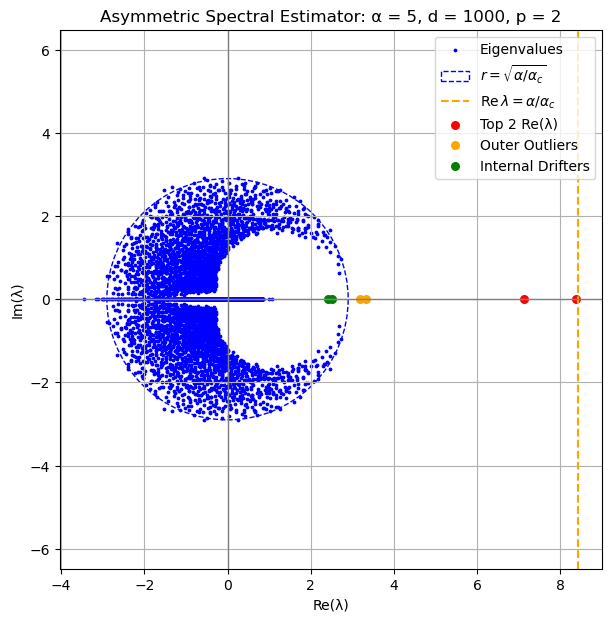


=== Alignment Score for Individual Eigenvalues ===
      Type                   λ  Alignment Score
0   Green1  2.518503+0.000000j         0.075713
1   Green2  2.405552+0.000000j         0.023034
2  Orange1  3.342570+0.000000j         0.041104
3  Orange2  3.190171+0.000000j         0.066204
4     Red1  8.379403+0.000000j         0.600430
5     Red2  7.132934+0.000000j         0.349098

=== Alignment Score for Pairs of Eigenvalues ===
               Pair                  λ1                  λ2  Alignment Score
14        Red1-Red2  8.379403+0.000000j  7.132934+0.000000j         0.600430
0     Green1-Green2  2.518503+0.000000j  2.405552+0.000000j         0.075713
1    Green1-Orange1  2.518503+0.000000j  3.342570+0.000000j         0.075713
2    Green1-Orange2  2.518503+0.000000j  3.190171+0.000000j         0.075713
3       Green1-Red1  2.518503+0.000000j  8.379403+0.000000j         0.075713
4       Green1-Red2  2.518503+0.000000j  7.132934+0.000000j         0.075713
12     Orange2-Red1  3.

/var/folders/kl/6hy0lk_14w14xqln8byr8l940000gn/T/ipykernel_55800/850667457.py:203: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


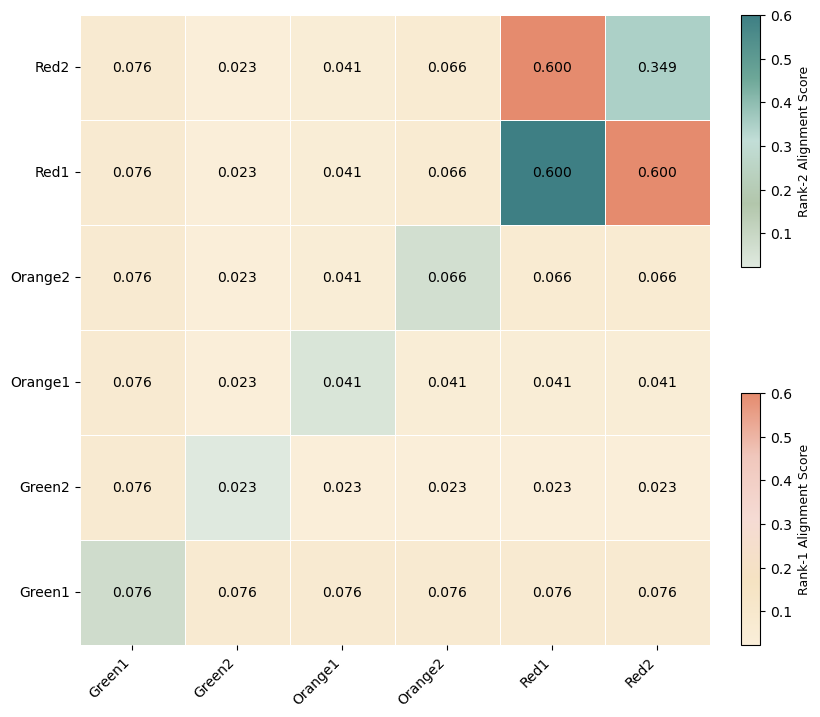

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from numpy.linalg import norm
from scipy.linalg import qr
from itertools import combinations
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Compute alignment score between estimated and true subspaces
def alignment_score(W_hat, W_star):
    Q1, _ = qr(W_hat, mode='economic')
    Q2, _ = qr(W_star, mode='economic')
    overlap = Q1.T @ Q2
    _, s, _ = np.linalg.svd(overlap)
    return np.mean(s)

# Extract estimated subspace from a single eigenvector
def extract_W_from_eigenvectors(eigvecs_np, eigval_target, X, W_star, p=2, label=""):
    idx = np.argmin(np.abs(eigvals_np - eigval_target))
    v_hat = eigvecs_np[:, idx]
    V = v_hat.reshape(-1, p)
    U = (X.cpu().numpy().T) @ V
    W_hat = U / np.linalg.norm(U, axis=0, keepdims=True)
    score = alignment_score(W_hat, W_star.cpu().numpy())
    return (label, eigval_target, score)

# Extract estimated subspace from a pair of eigenvectors
def extract_W_from_eigpair(eigvecs_np, eigvals_np, eigval_pair, X, W_star, p=2, label=""):
    idx1 = np.argmin(np.abs(eigvals_np - eigval_pair[0]))
    idx2 = np.argmin(np.abs(eigvals_np - eigval_pair[1]))
    v1 = eigvecs_np[:, idx1]
    v2 = eigvecs_np[:, idx2]
    V1 = v1.reshape(-1, p)
    V2 = v2.reshape(-1, p)
    V = np.hstack([V1, V2])
    U = X.cpu().numpy().T @ V
    W_hat = U[:, :p]
    W_hat = W_hat / norm(W_hat, axis=0, keepdims=True)
    score = alignment_score(W_hat, W_star.cpu().numpy())
    return (label, eigval_pair[0], eigval_pair[1], score)

# Eigendecomposition
eigvals, eigvecs = torch.linalg.eig(L)
eigvals_np = eigvals.cpu().numpy()
eigvecs_np = eigvecs.cpu().numpy()

# Classify eigenvalues into categories
R = np.sqrt(alpha / alpha_c)  # Spectral radius threshold
eigvals_np = eigvals.cpu().numpy()
eigvals_real_only = [z for z in eigvals_np if np.isclose(z.imag, 0.0, atol=1e-6)]

# Red: top two real eigenvalues outside radius
outside_radius = [z for z in eigvals_real_only if abs(z) > R and z.real > 0]
red_vals = sorted(outside_radius, key=lambda z: z.real, reverse=True)[:2]

# Orange: other positive eigenvalues outside radius
orange_vals = [z for z in outside_radius if z not in red_vals]

# Green: top two real eigenvalues inside radius
green_candidates = [z for z in eigvals_real_only if abs(z) <= R]
green_vals = sorted(green_candidates, key=lambda z: z.real, reverse=True)[:2]

# Assign labels by descending real part
green_vals_sorted = sorted(green_vals, key=lambda z: z.real, reverse=True)
green_labels = [(f"Green{i+1}", z) for i, z in enumerate(green_vals_sorted)]

orange_vals_sorted = sorted(orange_vals, key=lambda z: z.real, reverse=True)
orange_labels = [(f"Orange{i+1}", z) for i, z in enumerate(orange_vals_sorted)]

red_vals_sorted = sorted(red_vals, key=lambda z: z.real, reverse=True)
red_labels = [(f"Red{i+1}", z) for i, z in enumerate(red_vals_sorted)]

# Combine all labels
all_labels = green_labels + orange_labels + red_labels
label_order = [label for label, _ in all_labels]

# Eigenvalue spectrum plot
plt.figure(figsize=(7, 7))
plt.scatter(eigvals_np.real, eigvals_np.imag, color="blue", s=3, label="Eigenvalues")
circle = plt.Circle((0, 0), R, color="blue", linestyle="--", fill=False,
                    label=r"$r = \sqrt{\alpha/\alpha_c}$")
plt.gca().add_artist(circle)
plt.axvline(thresh_ext, color="orange", linestyle="--",
            label=r"$\mathrm{Re}\,\lambda = \alpha/\alpha_c$")
plt.scatter([z.real for _, z in red_labels], [z.imag for _, z in red_labels],
            color="red", s=30, label="Top 2 Re(λ)")
plt.scatter([z.real for _, z in orange_labels], [z.imag for _, z in orange_labels],
            color="orange", s=30, label="Outer Outliers")
plt.scatter([z.real for _, z in green_labels], [z.imag for _, z in green_labels],
            color="green", s=30, label="Internal Drifters")
plt.axhline(0, color='gray', linewidth=1)
plt.axvline(0, color='gray', linewidth=1)
plt.xlabel("Re(λ)")
plt.ylabel("Im(λ)")
plt.title(f"Asymmetric Spectral Estimator: α = {alpha}, d = {d}, p = 2")
plt.legend()
plt.grid(True)
plt.axis("equal")
plt.show()

# Compute rank-1 alignment scores
results_single = []
for label, z in all_labels:
    results_single.append(extract_W_from_eigenvectors(eigvecs_np, z, X, W_star, p=2, label=label))
df_single = pd.DataFrame(results_single, columns=["Type", "λ", "Alignment Score"])
print("\n=== Alignment Score for Individual Eigenvalues ===")
print(df_single)

# Compute rank-2 alignment scores
results_pair = []
for (label1, z1), (label2, z2) in combinations(all_labels, 2):
    pair_label = f"{label1}-{label2}"
    results_pair.append(extract_W_from_eigpair(eigvecs_np, eigvals_np, (z1, z2),
                                              X, W_star, p=2, label=pair_label))
df_pair = pd.DataFrame(results_pair, columns=["Pair", "λ1", "λ2", "Alignment Score"])
print("\n=== Alignment Score for Pairs of Eigenvalues ===")
print(df_pair.sort_values(by="Alignment Score", ascending=False))

# Construct heatmap data
heatmap_df = pd.DataFrame(np.nan, index=label_order, columns=label_order)
for _, row in df_single.iterrows():
    heatmap_df.loc[row["Type"], row["Type"]] = row["Alignment Score"]
for _, row in df_pair.iterrows():
    l1, l2 = row["Pair"].split("-")
    heatmap_df.loc[l1, l2] = row["Alignment Score"]
    heatmap_df.loc[l2, l1] = row["Alignment Score"]

# Define colormaps
diag_colors = ["#FAEED9", "#F5E3C2", "#F5DBD4", "#F0C7BC", "#E58B6E"]
offdiag_colors = ["#DFE9DF", "#B2C6AB", "#C2DED7", "#6DA798", "#3E7F84"]
diag_cmap = LinearSegmentedColormap.from_list("diag_cmap", diag_colors)
offdiag_cmap = LinearSegmentedColormap.from_list("offdiag_cmap", offdiag_colors)

# Masks
mask_diag = pd.DataFrame(True, index=label_order, columns=label_order)
np.fill_diagonal(mask_diag.values, False)
mask_offdiag = ~mask_diag

# Value range
vmin = np.nanmin(heatmap_df.values)
vmax = np.nanmax(heatmap_df.values)

# Plot heatmap
fig, ax = plt.subplots(figsize=(8, 7))
sns.heatmap(heatmap_df, mask=mask_diag, cmap=offdiag_cmap, vmin=vmin, vmax=vmax,
            square=True, linewidths=0.5, cbar=False, ax=ax)
cbar_ax1 = inset_axes(ax, width="3%", height="40%", loc='upper right',
                      bbox_to_anchor=(0.08, 0, 1, 1),
                      bbox_transform=ax.transAxes, borderpad=0)
sm1 = plt.cm.ScalarMappable(cmap=offdiag_cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
fig.colorbar(sm1, cax=cbar_ax1).set_label("Rank-2 Alignment Score", fontsize=9)

sns.heatmap(heatmap_df, mask=mask_offdiag, cmap=diag_cmap, vmin=vmin, vmax=vmax,
            square=True, linewidths=0.5, cbar=False, ax=ax)
cbar_ax2 = inset_axes(ax, width="3%", height="40%", loc='lower right',
                      bbox_to_anchor=(0.08, 0, 1, 1),
                      bbox_transform=ax.transAxes, borderpad=0)
sm2 = plt.cm.ScalarMappable(cmap=diag_cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
fig.colorbar(sm2, cax=cbar_ax2).set_label("Rank-1 Alignment Score", fontsize=9)

# Annotate values
for i in range(len(label_order)):
    for j in range(len(label_order)):
        val = heatmap_df.iloc[i, j]
        if not np.isnan(val):
            ax.text(j + 0.5, i + 0.5, f"{val:.3f}", ha='center', va='center', fontsize=10)

# Final adjustments
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.invert_yaxis()
plt.tight_layout()
plt.subplots_adjust(left=0.05, right=0.90, top=0.95, bottom=0.05)
plt.show()


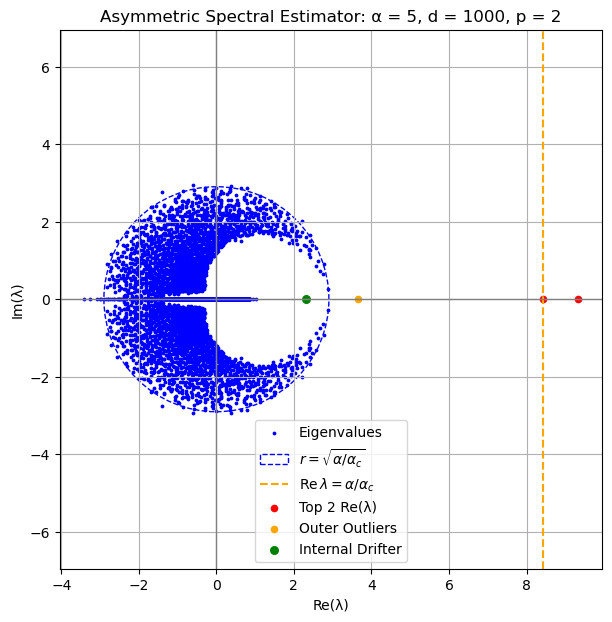

       Type      λ (eigval)  Alignment Score
0     Red-1  8.4258+0.0000j           0.5074
1     Red-2  9.3182+0.0000j           0.6511
2  Orange-1  3.6645+0.0000j           0.0551
3   Green-1  2.3144+0.0000j           0.0681


In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from numpy.linalg import norm
from scipy.linalg import qr
import pandas as pd

# Alignment score between estimated and true subspaces
def alignment_score(W_hat, W_star):
    Q1, _ = qr(W_hat, mode='economic')
    Q2, _ = qr(W_star, mode='economic')
    overlap = Q1.T @ Q2
    _, s, _ = np.linalg.svd(overlap)
    return np.mean(s)

# Extract estimated subspace from a single eigenvector and compute alignment
def extract_W_from_eigenvectors(eigvecs_np, eigval_target, X, W_star, p=2, label=""):
    idx = np.argmin(np.abs(eigvals_np - eigval_target))
    v_hat = eigvecs_np[:, idx]           # shape: (n*p,)
    V = v_hat.reshape(-1, p)             # shape: (n, p)
    U = (X.cpu().numpy().T) @ V          # shape: (d, p)
    W_hat = U / np.linalg.norm(U, axis=0, keepdims=True)
    score = alignment_score(W_hat, W_star.cpu().numpy())
    return (label, eigval_target, score)

# Eigendecomposition and data extraction
eigvals, eigvecs = torch.linalg.eig(L)
eigvals_np = eigvals.cpu().numpy()
eigvecs_np = eigvecs.cpu().numpy()
W_star_np = W_star.cpu().numpy()
d = W_star_np.shape[0]

R = np.sqrt(alpha / alpha_c)            # Spectral radius threshold
thresh_ext = alpha / alpha_c            # Jump threshold on the real axis

# Filter near-real eigenvalues
real_mask = np.isclose(eigvals_np.imag, 0.0, atol=1e-6)
eigvals_real_only = eigvals_np[real_mask]
real_parts = eigvals_real_only.real

# Select top-10 real eigenvalues
top10_real_idx = np.argsort(real_parts)[-10:]
top10_real_vals = eigvals_real_only[top10_real_idx]

# Red: top 2 eigenvalues
red_vals = top10_real_vals[-2:]

# Remaining candidates
rest_vals = top10_real_vals[:-2]
orange_vals = []
green_candidates = []
for val in rest_vals:
    if R < val.real < thresh_ext:
        orange_vals.append(val)
    elif val.real < R:
        green_candidates.append(val)

# Green: top eigenvalue inside spectral radius
green_single_val = None
inside_real_mask = np.logical_and(
    np.abs(eigvals_np) <= R,
    np.isclose(eigvals_np.imag, 0.0, atol=1e-6)
)
eigvals_real_inside = eigvals_np[inside_real_mask]
if eigvals_real_inside.size > 0:
    max_real_idx = np.argmax(eigvals_real_inside.real)
    green_single_val = eigvals_real_inside[max_real_idx]

# Spectrum visualization
plt.figure(figsize=(7, 7))
plt.scatter(eigvals_np.real, eigvals_np.imag, color="blue", s=3, label="Eigenvalues")
circle = plt.Circle((0, 0), R, color="blue", linestyle="--", fill=False,
                    label=r"$r = \sqrt{\alpha/\alpha_c}$")
plt.gca().add_artist(circle)
plt.axvline(thresh_ext, color="orange", linestyle="--",
            label=r"$\mathrm{Re}\,\lambda = \alpha/\alpha_c$")

plt.scatter([z.real for z in red_vals], [z.imag for z in red_vals],
            color="red", s=20, label="Top 2 Re(λ)")
plt.scatter([z.real for z in orange_vals], [z.imag for z in orange_vals],
            color="orange", s=20, label="Outer Outliers")
if green_single_val is not None:
    plt.scatter(green_single_val.real, green_single_val.imag,
                color="green", s=30, label="Internal Drifter")

plt.axhline(0, color='gray', linewidth=1)
plt.axvline(0, color='gray', linewidth=1)
plt.xlabel("Re(λ)")
plt.ylabel("Im(λ)")
plt.title(f"Asymmetric Spectral Estimator: α = {alpha}, d = {d}, p = 2")
plt.legend()
plt.grid(True)
plt.axis("equal")
plt.show()

# Compute alignment scores
results = []

# Red points
for i, val in enumerate(red_vals):
    label = f"Red-{i+1}"
    results.append(extract_W_from_eigenvectors(eigvecs_np, val, X, W_star, p=2, label=label))

# Orange points
for i, val in enumerate(orange_vals):
    label = f"Orange-{i+1}"
    results.append(extract_W_from_eigenvectors(eigvecs_np, val, X, W_star, p=2, label=label))

# Green point (only one)
if green_single_val is not None:
    results.append(extract_W_from_eigenvectors(
        eigvecs_np, green_single_val, X, W_star, p=2, label="Green-1"))

# Display alignment results
df = pd.DataFrame(results, columns=["Type", "λ (eigval)", "Alignment Score"])
pd.set_option("display.precision", 4)
print(df)
